In [1]:
from bs4 import BeautifulSoup
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import urllib
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# first we need to get the stats from the web

In [3]:
# get html from url

#r = urllib.request.urlopen('https://www.basketball-reference.com/leagues/NBA_2017_advanced.html').read()
r = urllib.request.urlopen('https://www.basketball-reference.com/leagues/NBA_2017_totals.html').read()

soup = BeautifulSoup(r, "html.parser")

In [4]:
# get the table with the stats
# and get the rows which contain the data we want
# need to look at the HTML and find the id of the table you want

#table = soup.find('table', {'id':'advanced_stats'})
table = soup.find('table', {'id':'totals_stats'})

# the data rows have class 'full_table'
data_rows = table.find_all(attrs={'class':'full_table'})

In [5]:
# make a list of dictionaries with the stats
# all the entries are strings so remember to convert to appropriate type later
data = [{x['data-stat']:x.text for x in r} for r in data_rows]

In [6]:
# exclude fields which are not numeric or of interest
excluded = ['player', 'team_id', 'pos', 'Xxx', 'Yyy', 'ranker', 'age']
keys = [key for key in sorted(data[0]) if key not in excluded]
n_keys = len(keys)

In [7]:
# make a data matrix of shape (n_players, n_stats)
# put 0.0 if a stat is empty
X = np.array([[float(p[key]) if p[key] else 0.0 for key in sorted(p) if key not in excluded] for p in data])
# only pick the players (rows) which have played more than n_g games
n_g = 20
chosen_players = [i for i, p in enumerate(data) if float(p['g']) > n_g]
n_players = len(chosen_players)
X = X[chosen_players]

In [8]:
# normalize data to have mean 0 and variance 1
# save an unnormalized copy Y
Y = X
mu = np.mean(X, axis=0)
sigma = np.sqrt(np.var(X, axis=0))
X = (X - mu)/sigma

In [9]:
# try cluster means with different number of clusters
kms = [KMeans(n_clusters=i) for i in range(1,20)]
scores = [km.fit(X).score(X) for km in kms]

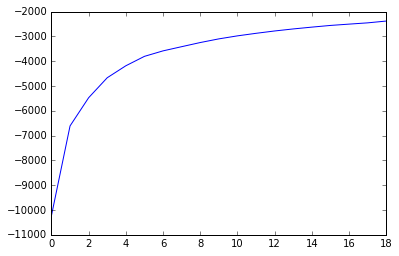

In [10]:
# look at the scores for different k
plt.plot(scores)

In [11]:
# pick k
k = 3
km = KMeans(n_clusters=k, max_iter=1000, n_init=20)
km.fit(X)
# array with cluster label
clusters = km.predict(X)

In [12]:
# pca
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X)

In [13]:
# look at what the principal axes are
principal_axes = [[(pca.components_[i, j], keys[j]) for j in np.abs(pca.components_[i]).argsort()[::-1]] for i in range(2)]

In [14]:
# centers in PA space
reduced_centers = pca.transform(km.cluster_centers_)

In [15]:
# centers in the observation space
centers = km.cluster_centers_*sigma + mu

In [16]:
# labels for the center
center_labels = [[(centers[j][i], keys[i]) for i in range(n_keys)] for j in range(k)]

In [17]:
# names of players for labeling
names = ['{} {}'.format(data[i]['player'], data[i]['pos']) for i in chosen_players]

In [18]:
# color map for putting different clusters
cmap = plt.get_cmap('Set1', k)

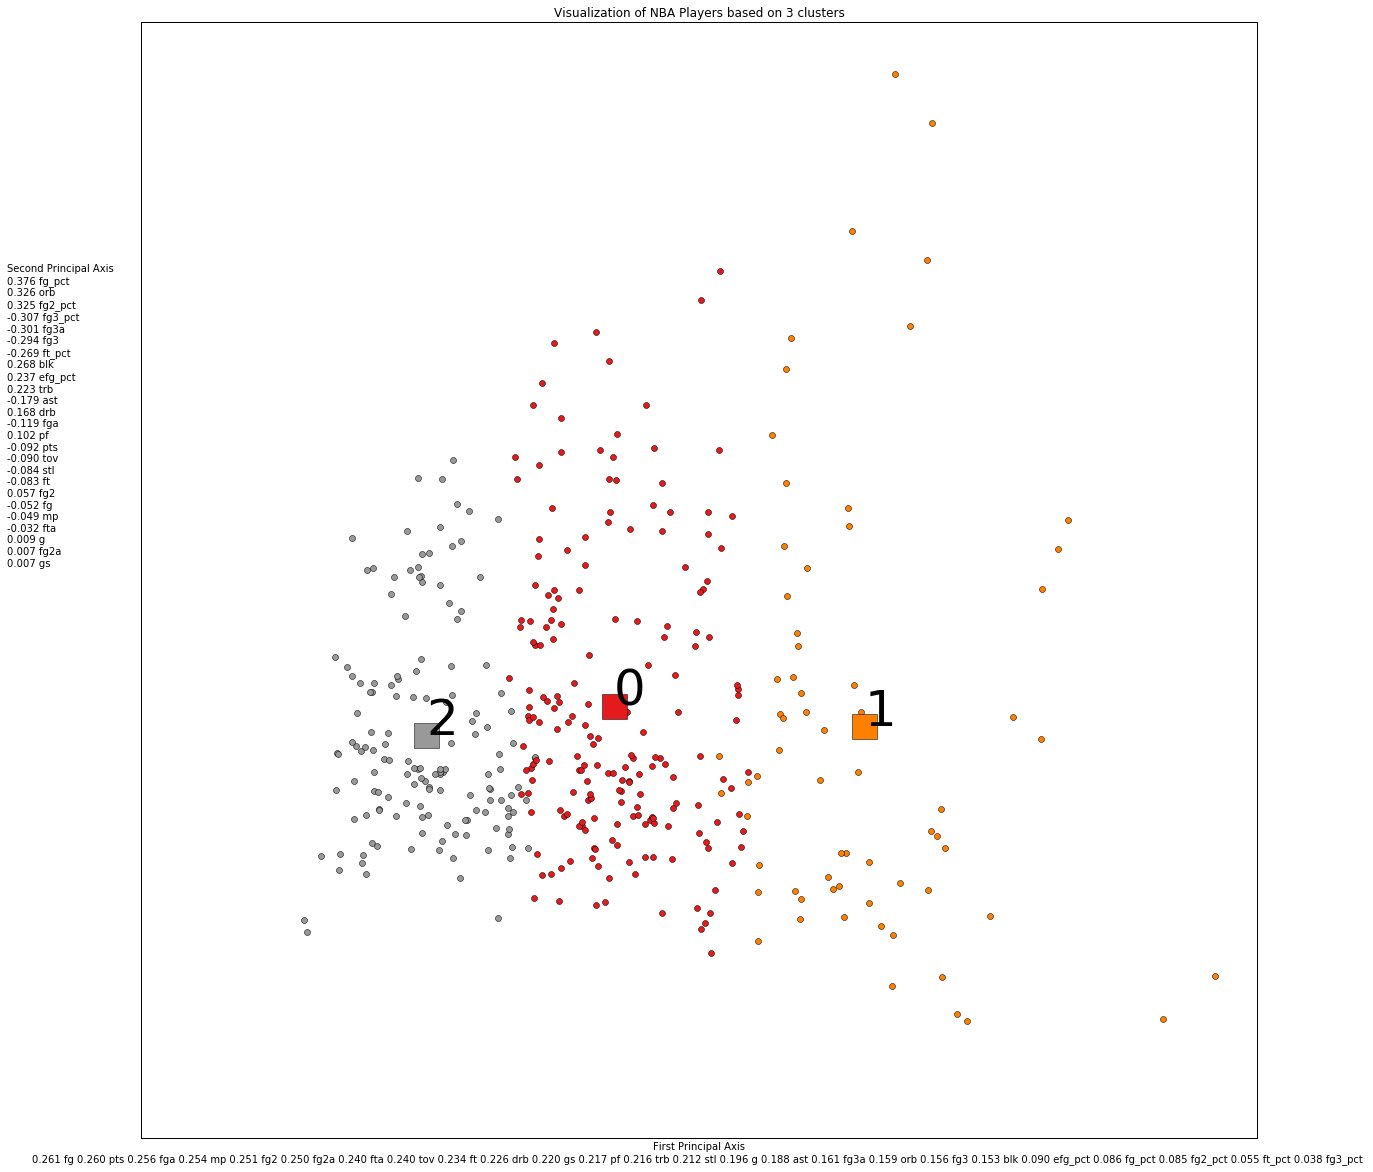

In [19]:
# plot all the players
fig = plt.figure(figsize=(20,20))

# take numbers of the axes since they are in normalized space and not very intuitive 
plt.tick_params(axis='both', 
                which='both', 
                bottom='off', 
                top='off', 
                labelbottom='off', 
                right='off', 
                left='off', 
                labelleft='off')

# label the principal axes
xlabel = 'First Principal Axis\n'
for val, lab in principal_axes[0]:
    xlabel += '{:3.3f} {} '.format(val, lab)
plt.xlabel(xlabel)

ylabel = 'Second Principal Axis\n'
for val, lab in principal_axes[1]:
    ylabel += '{:3.3f} {}\n'.format(val, lab)
plt.ylabel(ylabel, rotation='horizontal', horizontalalignment='left')

fig.axes[0].yaxis.set_label_coords(-0.12,0.5)

plt.title('Visualization of NBA Players based on {} clusters'.format(k))
for i in range(n_players):
    plt.plot(reduced_X[i,0], reduced_X[i,1], marker='o', color=cmap(clusters[i]))
for i in range(k):
    plt.plot(reduced_centers[i,0], reduced_centers[i,1], marker='s', color=cmap(i), markersize=25)
    plt.annotate(i, xy=(reduced_centers[i,0], reduced_centers[i,1]), fontsize=50)

plt.savefig('all_clusters.png', dpi=160)
plt.show()


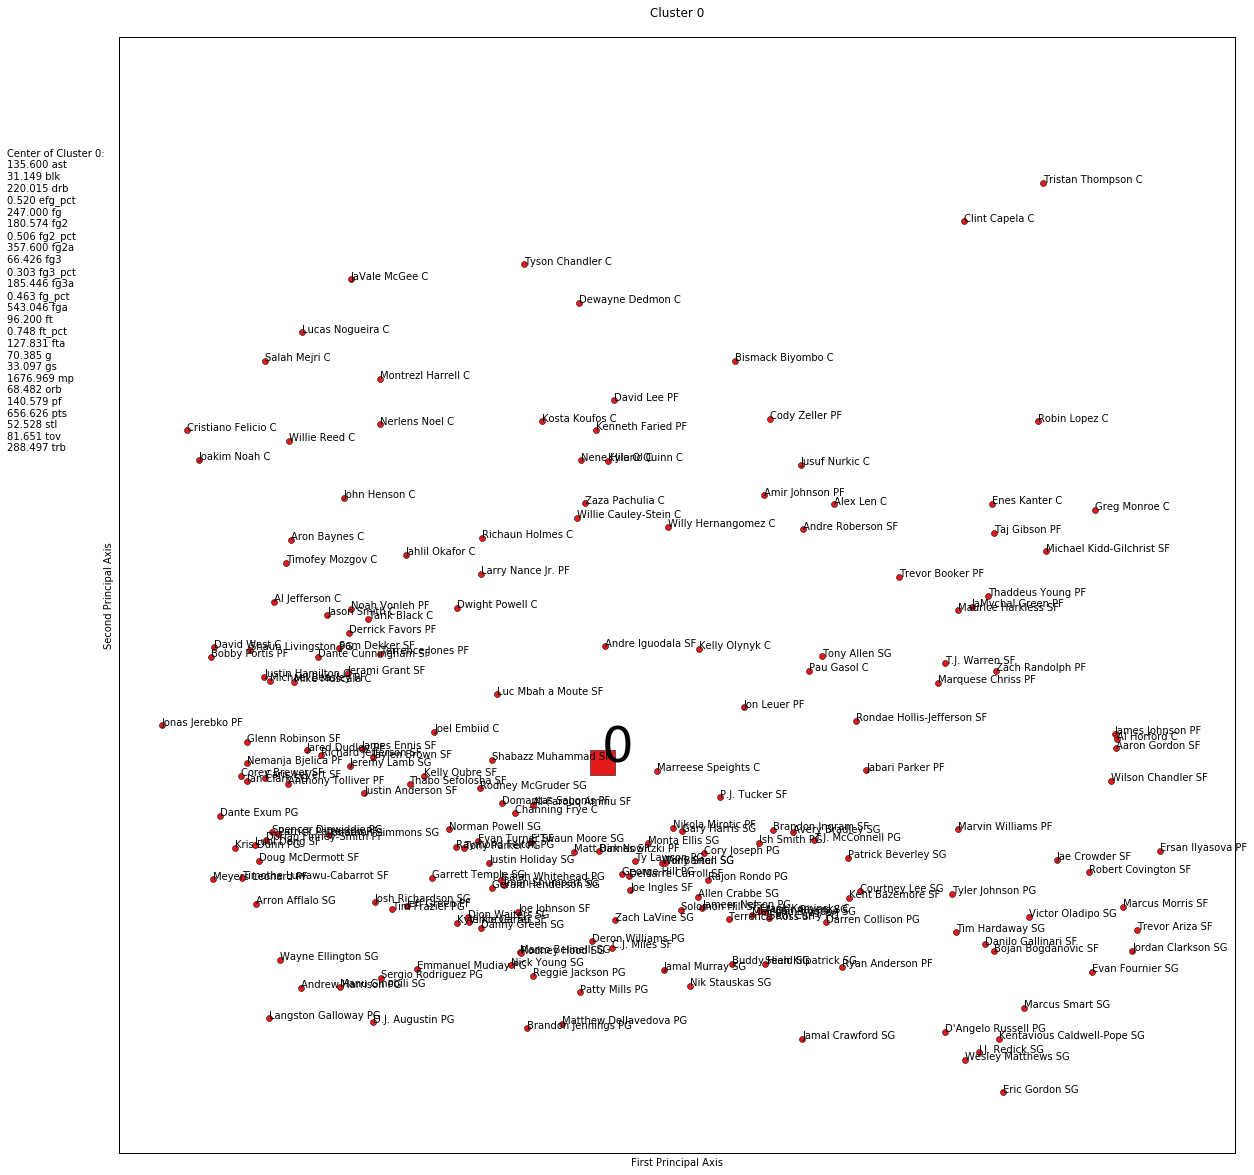

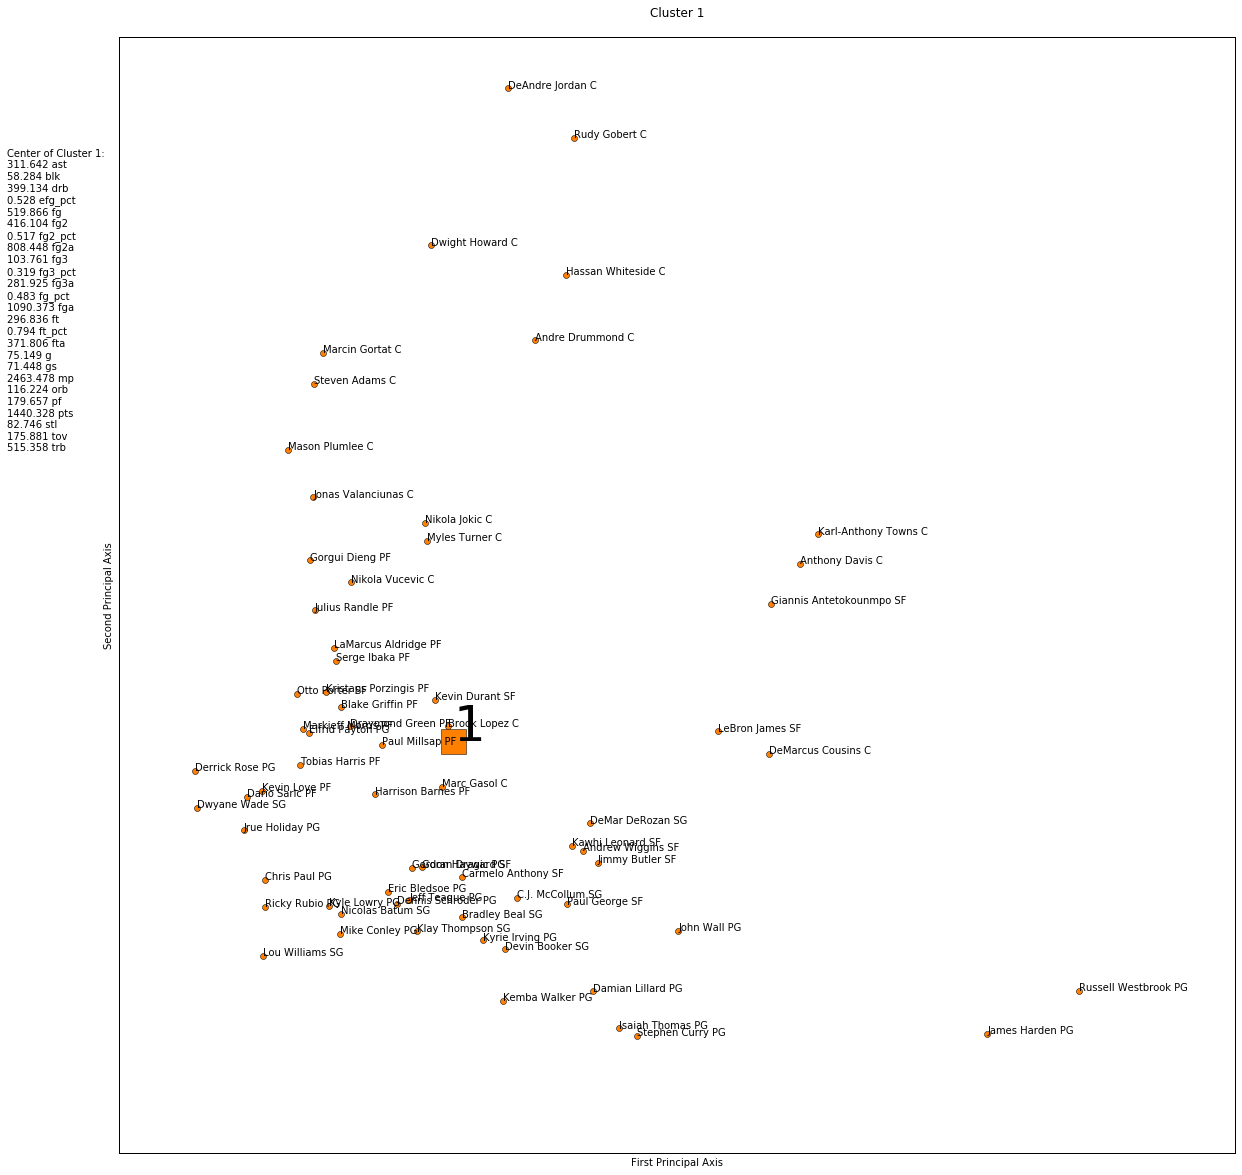

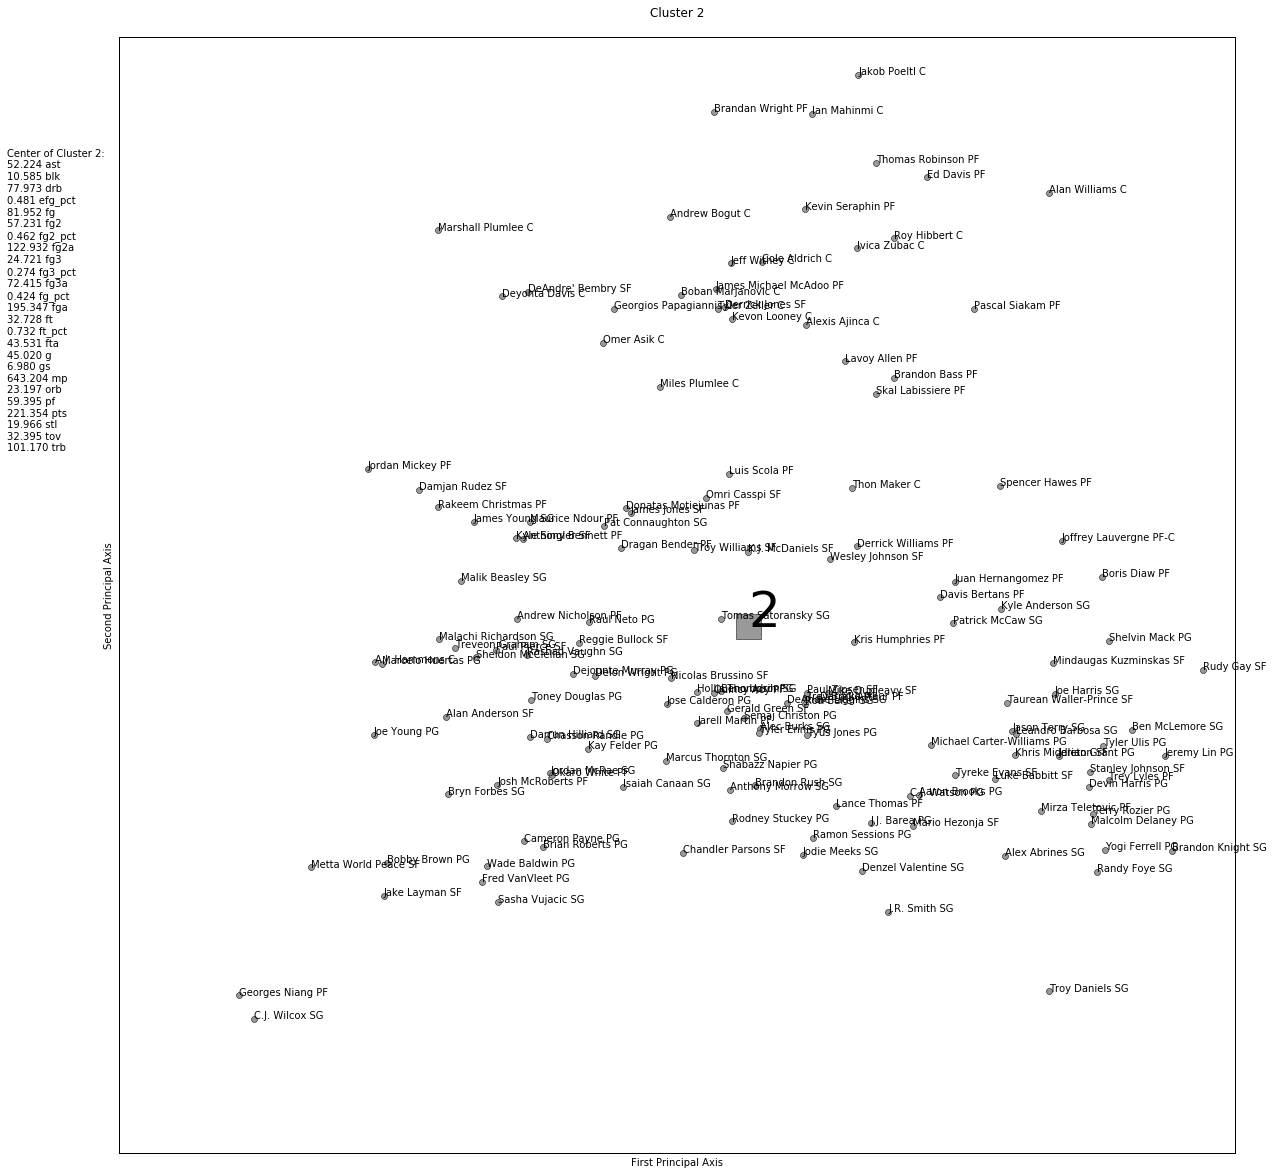

In [20]:
# plot each cluster separately
for c in range(k):
    fig = plt.figure(figsize=(20,20))
    plt.xlabel('First Principal Axis')
    plt.ylabel('Second Principal Axis')
    plt.title('Cluster {}\n'.format(c))
    
    # take numbers of the axes since they are in normalized space and not very intuitive 
    plt.tick_params(axis='both', 
                which='both', 
                bottom='off', 
                top='off', 
                labelbottom='off', 
                right='off', 
                left='off', 
                labelleft='off')  
    
    # coordinates of the center in observation space
    cen = 'Center of Cluster {}:\n'.format(c)
    for val, lab in center_labels[c]:
        cen += '{:3.3f} {}\n'.format(val, lab)
    plt.text(-0.1,0.9,cen, va='top', transform=fig.axes[0].transAxes)
    
    
    for i in range(n_players):
        if clusters[i] == c:
            x = reduced_X[i,0]
            y = reduced_X[i,1]
            l = names[i]
            plt.plot(x, y, marker='o', color=cmap(clusters[i]))
            plt.annotate(l, (x,y))
    # plot the center
    plt.plot(reduced_centers[c, 0], reduced_centers[c, 1], marker='s', color=cmap(c), markersize=25 )
    plt.annotate(c, xy=(reduced_centers[c,0], reduced_centers[c,1]), fontsize=50)
    # show the plot

    plt.savefig('cluster_{}.png'.format(c), dpi=160)   
    plt.show()